<a href="https://colab.research.google.com/github/harry-zhao78/colab/blob/master/5%E5%88%86%E9%92%9F%E6%95%B0%E6%8D%AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
data_to_load = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/My Drive/datasets/SH1min.csv"
#df= pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras


import matplotlib as mpl
from matplotlib import pyplot as plt

from numpy import array
from numpy import hstack

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from sklearn import preprocessing


mpl.rcParams['figure.figsize'] = (15, 10)


#-------------------------------------------------------------------------------


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(90)

#-------------------------------------------------------------------------------
#saving and loading model


#model_save_name = 'dense.h5'
#path = F"/content/drive/My Drive/{model_save_name}" 
#model.save(path)
#model=keras.models.load_model(path) 

#-------------------------------------------------------------------------------
#for model evaluation



# ytrue=denorm(y_test,df.target)
# yhat=denorm(model.predict(X_test),df.target)

# model.evaluate(X_test,y_test)
# print("sklearn mae：",sklearn.metrics.mean_absolute_error(ytrue,yhat))

# gene_hist(ytrue,yhat)
# calculate_profit(ytrue,yhat)


In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
# find the end of this pattern
    end_ix = i + n_steps
# check if we are beyond the dataset
    if end_ix > len(sequences):
      break
# gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

#-------------------------------------------------------------------------------


def denorm (prediction,col):
  max=np.max(col)
  min=np.min(col)
  denormed=prediction*(max-min)+min
  denormed=denormed.reshape((len(prediction),1))
  return denormed    

#-------------------------------------------------------------------------------

def gene_hist(a,b):

  error = b - a
  plt.hist(error, bins = 200)
  plt.xlabel("Prediction Error")
  plt.xlim(-100, 100)
  _ = plt.ylabel("Count")   

#-------------------------------------------------------------------------------

def gene_scat(a,b):
  time=np.arange(0,len(a),1)
  plt.plot(time,a)
  plt.plot(time,b)


#ytrue=denorm(y_test,df.target)
#yhat=denorm(model.predict(X_test),df.target)
#gene_scat(ytrue,yhat)

#-------------------------------------------------------------------------------

def gene_df(a,b):
  a=pd.DataFrame(a)
  b=pd.DataFrame(b)
  c=pd.concat([a,b],axis=1)
  c.columns = ["ytrue", "yhat"]
  return c

#-------------------------------------------------------------------------------


def calculate_profit(ytrue,yhat):

  #t, ytrue(t+1), yhat(t+1)
  returns=gene_df(ytrue,yhat)
  returns["t"]=returns.ytrue.shift(1)
  returns=pd.concat([returns.t,returns.ytrue,returns.yhat],axis=1)
  returns=returns.drop(returns.head(1).index) # drop first n rows

  money_array=[]
  pos=0
  money=0
  pos_array=[]

  for ind, row in returns.iterrows():
    if row.yhat>row.t and pos==0:
      money=money-row.t
      money_array.append(money+row.t)
      pos=pos+1

    elif row.yhat<row.t and pos==1:
      money=money+row.t
      money_array.append(money)
      pos=pos-1
    
    else:
      if len(money_array)==0:
        money_array.append(0)
      else:
        money_array.append(money_array[-1])

    pos_array.append(pos)

    
  if pos==1:
    money=money+returns.iloc[-1]["t"] 
    pos=pos-1

  returns["profit"]=np.array(money_array)
  returns["position"]=np.array(pos_array)

  returns=pd.concat([returns.t,returns.yhat,returns.ytrue,returns.profit,returns.position],axis=1)

  time=np.arange(0,len(money_array),1)
  plt.plot(time,money_array)

  
  print("profit is",money,"position in portfolio is",pos)
  print(len(money_array),returns.shape)
  return returns


In [ ]:
#data preparation

#df = pd.read_csv(path, parse_dates=['time'], index_col="time")
df = pd.read_csv(path, parse_dates=['DateTime'], index_col="DateTime")

df["target"]=df.close.shift(-1)
df=df.drop(df.tail(1).index) # drop last n rows
df=df[["close","target"]]

values=df.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit_transform(values)


X,y=split_sequences(scaled,1)
y=y.reshape(len(y),1)

a=130000
b=150000
X_train=X[:a]
y_train=y[:a]

X_val=X[a:b]
y_val=y[a:b]

X_test=X[1:]
y_test=y[1:]



In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



#### dense model use as baseline

# lloss: 2.9192e-05 - mean_absolute_error: 0.0034 sklearn mae： 3.8791945
model = keras.Sequential([
    keras.layers.Flatten(input_shape=[X.shape[1],X.shape[2]]), 
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1)])



model.compile(loss="mse",optimizer="adam")

checkpoint_cb = keras.callbacks.ModelCheckpoint("baseline.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb,early_stopping_cb,tensorboard_cb], shuffle=True)


Epoch 1/20
4063/4063 [==============================] - 5s 1ms/step - loss: 8.1015e-04 - val_loss: 4.2874e-06
Epoch 2/20
4063/4063 [==============================] - 5s 1ms/step - loss: 2.5481e-06 - val_loss: 4.2351e-06
Epoch 3/20
4063/4063 [==============================] - 4s 1ms/step - loss: 2.9508e-06 - val_loss: 4.2611e-06
Epoch 4/20
4063/4063 [==============================] - 5s 1ms/step - loss: 2.9673e-06 - val_loss: 4.2672e-06
Epoch 5/20
4063/4063 [==============================] - 4s 1ms/step - loss: 2.9025e-06 - val_loss: 6.3485e-06
Epoch 6/20
4063/4063 [==============================] - 4s 1ms/step - loss: 2.9214e-06 - val_loss: 4.5639e-06
Epoch 7/20
4063/4063 [==============================] - 4s 1ms/step - loss: 2.9325e-06 - val_loss: 4.4953e-06
Epoch 8/20
4063/4063 [==============================] - 5s 1ms/step - loss: 2.9442e-06 - val_loss: 4.2388e-06
Epoch 9/20
1619/4063 [==========>...................] - ETA: 2s - loss: 2.9966e-06

KeyboardInterrupt: ignored

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



#### dense model use as baseline

# lloss: 2.9192e-05 - mean_absolute_error: 0.0034 sklearn mae： 3.8791945
model = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True,
                             kernel_initializer="lecun_normal", input_shape=(X.shape[1],X.shape[2])),
    keras.layers.PReLU(),

    keras.layers.LSTM(64, return_sequences=True,
                             kernel_initializer="lecun_normal"),
       # keras.layers.BatchNormalization(),
    keras.layers.PReLU(),


    
    #keras.layers.Dropout(0.2),
    #keras.layers.BatchNormalization(),
    keras.layers.PReLU(),


    keras.layers.LSTM(32, return_sequences=True,
                             kernel_initializer="lecun_normal"),
       # keras.layers.BatchNormalization(),
    keras.layers.PReLU(),


    #keras.layers.Dropout(0.2),
    keras.layers.LSTM(32, return_sequences=True,
                             kernel_initializer="lecun_normal"),
    #keras.layers.Dropout(0.2),
    #keras.layers.BatchNormalization(),
    keras.layers.PReLU(),
    keras.layers.Dense(24),
    keras.layers.PReLU(),
    keras.layers.Dense(10),
    keras.layers.PReLU(),

    keras.layers.Dense(1)
])


model.compile(loss="mse",optimizer="adam")

checkpoint_cb = keras.callbacks.ModelCheckpoint("lstm.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb,early_stopping_cb,tensorboard_cb], shuffle=True)


Epoch 1/20
4063/4063 [==============================] - 53s 13ms/step - loss: 0.0020 - val_loss: 6.0276e-06
Epoch 2/20
4063/4063 [==============================] - 51s 13ms/step - loss: 7.6973e-06 - val_loss: 1.0105e-05
Epoch 3/20
4063/4063 [==============================] - 51s 12ms/step - loss: 6.9620e-06 - val_loss: 7.2376e-06
Epoch 4/20
4063/4063 [==============================] - 50s 12ms/step - loss: 7.0209e-06 - val_loss: 4.4548e-06
Epoch 5/20
4063/4063 [==============================] - 52s 13ms/step - loss: 6.2489e-06 - val_loss: 4.4157e-06
Epoch 6/20
4063/4063 [==============================] - 49s 12ms/step - loss: 5.7726e-06 - val_loss: 5.5944e-06
Epoch 7/20
4063/4063 [==============================] - 49s 12ms/step - loss: 5.8578e-06 - val_loss: 5.5578e-06
Epoch 8/20
4063/4063 [==============================] - 50s 12ms/step - loss: 5.8519e-06 - val_loss: 5.0941e-06
Epoch 9/20
4063/4063 [==============================] - 51s 13ms/step - loss: 6.1527e-06 - val_loss: 6.0758e

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True,  input_shape=(X.shape[1],X.shape[2])),
    keras.layers.Dropout(0.2),

    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val))

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

5513/5513 [==============================] - 20s 4ms/step - loss: 3.1169e-06
sklearn mae： 1.1316257


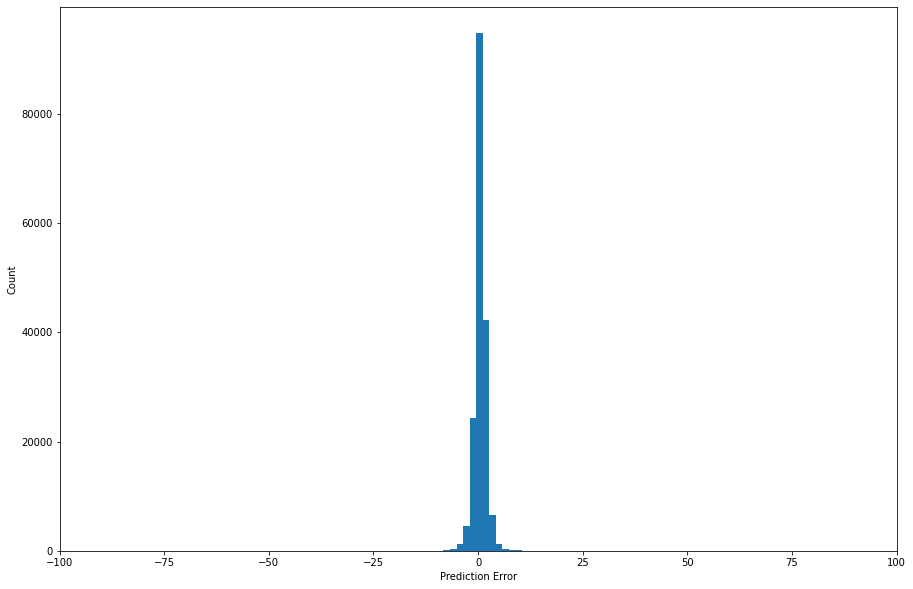

In [ ]:
model=keras.models.load_model("lstm.h5") 


ytrue=denorm(y_test,df.target)
yhat=denorm(model.predict(X_test),df.target)

model.evaluate(X_test,y_test)
print("sklearn mae：",sklearn.metrics.mean_absolute_error(ytrue,yhat))

gene_hist(ytrue,yhat)


profit is 243.071533203125 position in portfolio is 0
176415 (176415, 5)


,t,yhat,ytrue,profit,position
1,3279.919922,3280.683105,3278.530273,0.0,1
2,3278.530273,3279.304199,3280.280029,0.0,1
3,3280.280029,3281.040527,3280.520020,0.0,1
4,3280.520020,3281.278320,3281.060059,0.0,1
5,3281.060059,3281.813965,3280.729980,0.0,1
6,3280.729980,3281.486816,3279.310059,0.0,1
7,3279.310059,3280.078125,3277.830078,0.0,1
8,3277.830078,3278.609375,3277.429932,0.0,1
9,3277.429932,3278.212158,3275.389893,0.0,1
10,3275.389893,3276.186035,3274.720215,0.0,1


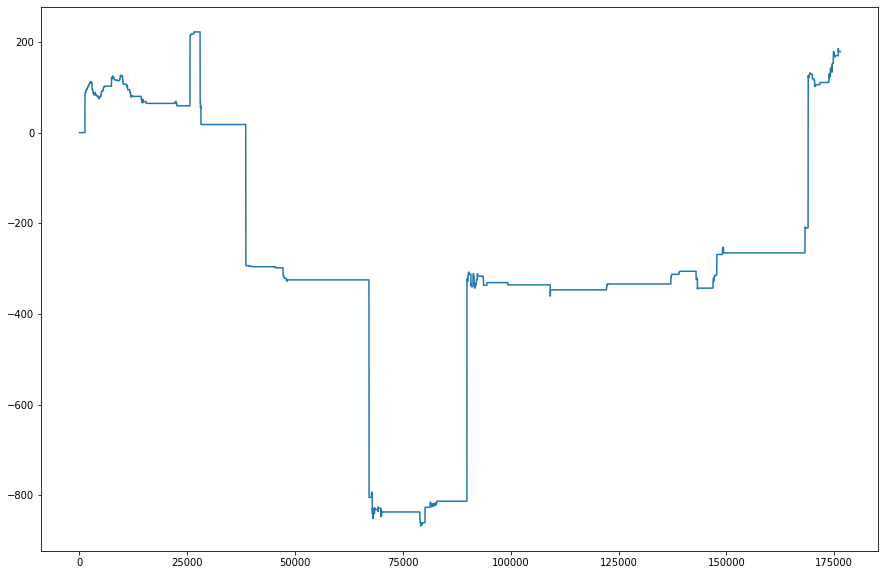

In [ ]:
calculate_profit(ytrue,yhat).head(60)


In [ ]:


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



#### dense model use as baseline

# loss: 2.8008e-05 - mean_absolute_error: 0.0033  sklearn mae： 3.7761397


model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[X.shape[1],X.shape[2]]))
for _ in range(7):
  model.add( keras.layers.Dense(units=7,activation="relu"))
model.add(keras.layers.Dense(units=15,activation="relu"))
model.add(keras.layers.Dense(units=5,activation="relu"))

model.add(keras.layers.Dense(units=1))


model.compile(loss="mse",
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

checkpoint_cb = keras.callbacks.ModelCheckpoint("baseline.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb,tensorboard_cb,early_stopping_cb], shuffle=True)


In [ ]:

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



#### dense model use as baseline

# loss: 2.8008e-05 - mean_absolute_error: 0.0033  sklearn mae： 3.7761397



model = keras.models.Sequential([
    keras.layers.SimpleRNN(30, return_sequences=True, input_shape=[X.shape[1],X.shape[2]]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.Dropout(rate=0.2),

    keras.layers.TimeDistributed(keras.layers.Dense(1))

])

model.compile(loss="mse",
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

checkpoint_cb = keras.callbacks.ModelCheckpoint("baseline.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb,tensorboard_cb], shuffle=True)


Epoch 1/100
782/782 [==============================] - 5s 6ms/step - loss: 0.0399 - mean_absolute_error: 0.1293 - val_loss: 4.9143e-04 - val_mean_absolute_error: 0.0153
Epoch 2/100
782/782 [==============================] - 4s 5ms/step - loss: 0.0044 - mean_absolute_error: 0.0497 - val_loss: 3.6216e-04 - val_mean_absolute_error: 0.0131
Epoch 3/100
782/782 [==============================] - 4s 5ms/step - loss: 0.0024 - mean_absolute_error: 0.0364 - val_loss: 2.8047e-04 - val_mean_absolute_error: 0.0116
Epoch 4/100
782/782 [==============================] - 4s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - val_loss: 2.1389e-04 - val_mean_absolute_error: 0.0093
Epoch 5/100
782/782 [==============================] - 4s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0284 - val_loss: 2.3661e-04 - val_mean_absolute_error: 0.0105
Epoch 6/100
782/782 [==============================] - 4s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0271 - val_loss: 2.1648e-04 - val_mean_absolute_

KeyboardInterrupt: ignored

In [ ]:
model.predict(X_test)

array([[0.5183906 ],
       [0.5224686 ],
       [0.5230979 ],
       ...,
       [0.79983646],
       [0.79839706],
       [0.7978742 ]], dtype=float32)

In [ ]:
model2=keras.models.load_model("baseline.h5")
model2.evaluate(X_test,y_test)
model.summary

159/159 [==============================] - 0s 751us/step - loss: 2.6260e-05 - mean_absolute_error: 0.0031


<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f7d578275f8>>

In [ ]:
model.evaluate(X_test,y_test)
model.summary


159/159 [==============================] - 0s 783us/step - loss: 2.6700e-05 - mean_absolute_error: 0.0032


<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f7d578275f8>>

In [ ]:

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



#### dense model use as baseline

# loss: 2.8008e-05 - mean_absolute_error: 0.0033  sklearn mae： 3.7761397
model = tf.keras.Sequential([
    keras.layers.Flatten(input_shape=[X.shape[1],X.shape[2]]),  
    keras.layers.Dropout(rate=0.2),
                 
    keras.layers.Dense(units=1280, activation='relu'),
    keras.layers.Dropout(rate=0.2),

    keras.layers.Dense(units=640, activation='relu'),
    keras.layers.Dropout(rate=0.2),

    keras.layers.Dense(units=320, activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=1)
])



model.compile(loss="mse",
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

checkpoint_cb = keras.callbacks.ModelCheckpoint("baseline.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=1,restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb,tensorboard_cb], shuffle=True)


Epoch 1/100
782/782 [==============================] - 9s 12ms/step - loss: 0.0112 - mean_absolute_error: 0.0571 - val_loss: 0.0061 - val_mean_absolute_error: 0.0713
Epoch 2/100
493/782 [=================>............] - ETA: 3s - loss: 0.0034 - mean_absolute_error: 0.0435

KeyboardInterrupt: ignored

In [ ]:


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



#### dense model use as baseline

# loss: 2.8008e-05 - mean_absolute_error: 0.0033  sklearn mae： 3.7761397
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[X.shape[1],X.shape[2]]), 
    tf.keras.layers.Dense(units=528, kernel_initializer="he_normal"),
    keras.layers.PReLU(),

    tf.keras.layers.Dense(units=328, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
  
    tf.keras.layers.Dense(units=128, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    tf.keras.layers.Dense(units=64, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    tf.keras.layers.Dense(units=32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    tf.keras.layers.Dense(units=1)
])


model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

checkpoint_cb = keras.callbacks.ModelCheckpoint("selu2.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=500, batch_size=256, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb,tensorboard_cb], shuffle=True)


Epoch 1/500
98/98 [==============================] - 2s 20ms/step - loss: 0.0464 - mean_absolute_error: 0.0649 - val_loss: 2.5768e-04 - val_mean_absolute_error: 0.0112
Epoch 2/500
98/98 [==============================] - 2s 18ms/step - loss: 1.4388e-04 - mean_absolute_error: 0.0091 - val_loss: 1.4630e-04 - val_mean_absolute_error: 0.0079
Epoch 3/500
98/98 [==============================] - 2s 18ms/step - loss: 1.0194e-04 - mean_absolute_error: 0.0076 - val_loss: 1.0944e-04 - val_mean_absolute_error: 0.0068
Epoch 4/500
98/98 [==============================] - 2s 17ms/step - loss: 7.3692e-05 - mean_absolute_error: 0.0064 - val_loss: 1.0478e-04 - val_mean_absolute_error: 0.0075
Epoch 5/500
98/98 [==============================] - 2s 17ms/step - loss: 7.6960e-05 - mean_absolute_error: 0.0067 - val_loss: 9.7154e-05 - val_mean_absolute_error: 0.0071
Epoch 6/500
98/98 [==============================] - 2s 17ms/step - loss: 7.7950e-05 - mean_absolute_error: 0.0067 - val_loss: 1.5202e-04 - val_

159/159 [==============================] - 0s 2ms/step - loss: 3.1103e-05 - mean_absolute_error: 0.0034
sklearn mae： 3.9013095


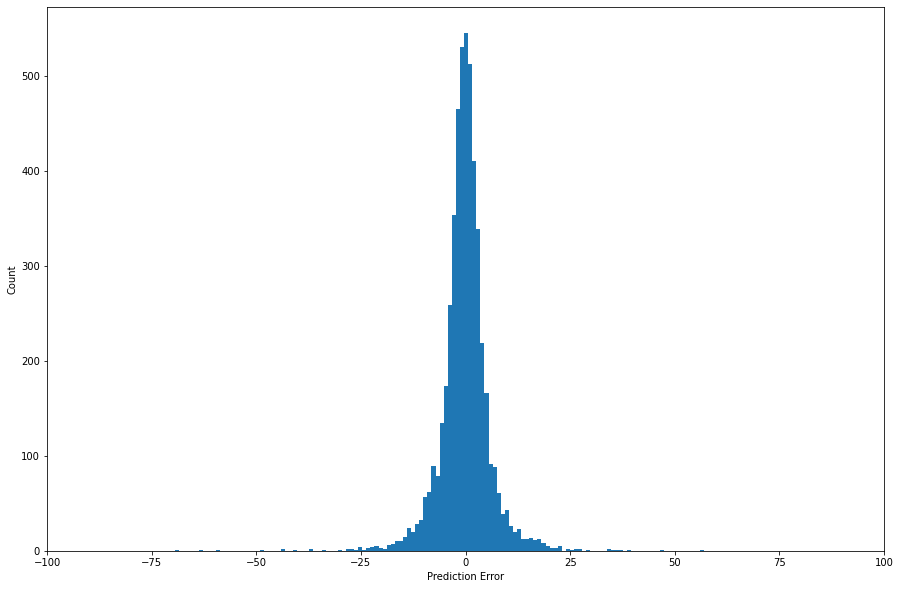

In [ ]:
model2=keras.models.load_model("selu2.h5") 
ytrue=denorm(y_test,df.target)
yhat=denorm(model2.predict(X_test),df.target)

model2.evaluate(X_test,y_test)
print("sklearn mae：",sklearn.metrics.mean_absolute_error(ytrue,yhat))

gene_hist(ytrue,yhat)


profit is 169.868896484375 position in portfolio is 0
5075 (5075, 5)


,t,yhat,ytrue,profit,position
1,3044.845703,3044.776367,3045.209961,0.000000,0
2,3045.209961,3046.358154,3044.386230,0.000000,1
3,3044.386230,3046.316650,3052.290039,0.000000,1
4,3052.290039,3051.814209,3052.827881,7.080078,0
5,3052.827881,3053.076904,3046.581787,7.080078,1
...,...,...,...,...,...
5071,3366.390869,3365.633545,3364.749023,166.811279,0
5072,3364.749023,3363.659424,3354.088379,166.811279,0
5073,3354.088379,3355.418213,3357.145996,166.811279,1
5074,3357.145996,3355.701416,3354.165771,169.868896,0


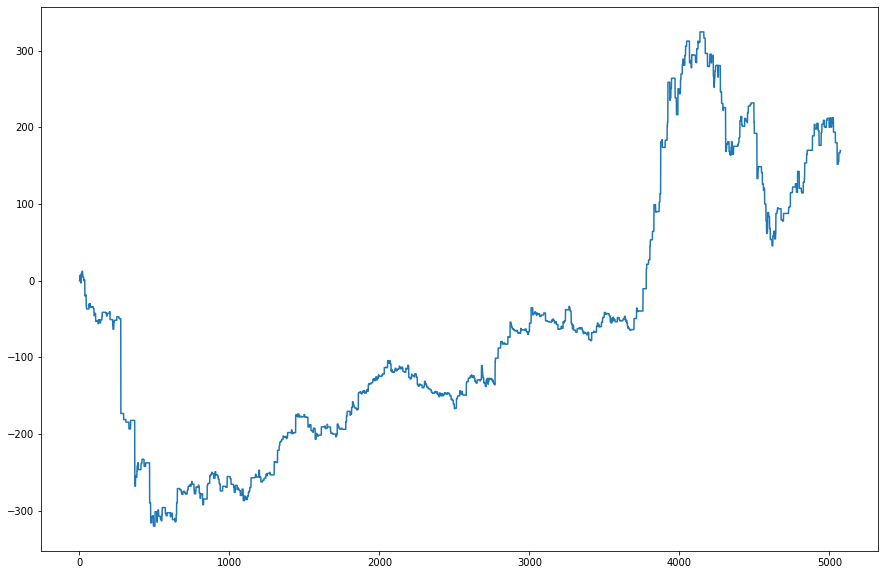

In [ ]:
calculate_profit(ytrue,yhat)


In [ ]:


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



#### dense model use as baseline

# loss: 2.8008e-05 - mean_absolute_error: 0.0033  sklearn mae： 3.7761397
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[X.shape[1],X.shape[2]]),                   
    tf.keras.layers.Dense(units=128, activation='elu',kernel_initializer="he_normal"),
    tf.keras.layers.Dense(units=64, activation='elu',kernel_initializer="he_normal"),
    tf.keras.layers.Dense(units=32, activation='elu',kernel_initializer="he_normal"),
    tf.keras.layers.Dense(units=1)
])



model.compile(loss="mse",
                optimizer= keras.optimizers.SGD(lr=0.01, momentum=0.9),
                metrics=[tf.metrics.MeanAbsoluteError()])

checkpoint_cb = keras.callbacks.ModelCheckpoint("baseline.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=150, batch_size=64, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb,tensorboard_cb], shuffle=True)


Epoch 1/150
782/782 [==============================] - 2s 3ms/step - loss: 0.0150 - mean_absolute_error: 0.0333 - val_loss: 3.6317e-04 - val_mean_absolute_error: 0.0113
Epoch 2/150
782/782 [==============================] - 2s 3ms/step - loss: 2.0614e-04 - mean_absolute_error: 0.0106 - val_loss: 2.8277e-04 - val_mean_absolute_error: 0.0106
Epoch 3/150
782/782 [==============================] - 2s 3ms/step - loss: 1.7704e-04 - mean_absolute_error: 0.0098 - val_loss: 2.9103e-04 - val_mean_absolute_error: 0.0103
Epoch 4/150
782/782 [==============================] - 2s 3ms/step - loss: 1.6104e-04 - mean_absolute_error: 0.0094 - val_loss: 2.3707e-04 - val_mean_absolute_error: 0.0096
Epoch 5/150
782/782 [==============================] - 2s 3ms/step - loss: 1.4763e-04 - mean_absolute_error: 0.0090 - val_loss: 2.2119e-04 - val_mean_absolute_error: 0.0083
Epoch 6/150
782/782 [==============================] - 2s 3ms/step - loss: 1.3446e-04 - mean_absolute_error: 0.0085 - val_loss: 1.8648e-04 

KeyboardInterrupt: ignored

In [ ]:

history = model.fit(X_train, y_train, epochs=300, batch_size=32,initial_epoch=151, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb,tensorboard_cb], shuffle=True)


Epoch 152/300
782/782 [==============================] - 2s 3ms/step - loss: 5.1202e-05 - mean_absolute_error: 0.0052 - val_loss: 8.2797e-05 - val_mean_absolute_error: 0.0054
Epoch 153/300
782/782 [==============================] - 2s 3ms/step - loss: 5.0655e-05 - mean_absolute_error: 0.0052 - val_loss: 8.1941e-05 - val_mean_absolute_error: 0.0053
Epoch 154/300
782/782 [==============================] - 2s 3ms/step - loss: 5.0607e-05 - mean_absolute_error: 0.0052 - val_loss: 8.2236e-05 - val_mean_absolute_error: 0.0054
Epoch 155/300
782/782 [==============================] - 2s 3ms/step - loss: 5.0381e-05 - mean_absolute_error: 0.0052 - val_loss: 8.3664e-05 - val_mean_absolute_error: 0.0054
Epoch 156/300
782/782 [==============================] - 2s 3ms/step - loss: 5.0184e-05 - mean_absolute_error: 0.0052 - val_loss: 8.1985e-05 - val_mean_absolute_error: 0.0053
Epoch 157/300
782/782 [==============================] - 2s 3ms/step - loss: 5.0087e-05 - mean_absolute_error: 0.0052 - val_l

KeyboardInterrupt: ignored

In [ ]:


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)



root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



#### dense model use as baseline

# loss: 2.8008e-05 - mean_absolute_error: 0.0033  sklearn mae： 3.7761397
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[X.shape[1],X.shape[2]]), 
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="relu"),

    tf.keras.layers.Dense(units=1)
])



model.compile(loss="mse",
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

checkpoint_cb = keras.callbacks.ModelCheckpoint("prelu.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=500, batch_size=128, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb,tensorboard_cb], shuffle=True)


Epoch 1/500
196/196 [==============================] - 2s 9ms/step - loss: 0.0277 - mean_absolute_error: 0.0990 - val_loss: 0.0038 - val_mean_absolute_error: 0.0469
Epoch 2/500
196/196 [==============================] - 1s 7ms/step - loss: 0.0035 - mean_absolute_error: 0.0457 - val_loss: 0.0022 - val_mean_absolute_error: 0.0374
Epoch 3/500
196/196 [==============================] - 2s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0389 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302
Epoch 4/500
196/196 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_absolute_error: 0.0339 - val_loss: 0.0014 - val_mean_absolute_error: 0.0269
Epoch 5/500
196/196 [==============================] - 2s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0297 - val_loss: 0.0012 - val_mean_absolute_error: 0.0230
Epoch 6/500
196/196 [==============================] - 1s 7ms/step - loss: 0.0016 - mean_absolute_error: 0.0315 - val_loss: 0.0014 - val_mean_absolute_error: 0.0279
Epoch 7/50

In [ ]:


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)



root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



#### dense model use as baseline

# loss: 2.8008e-05 - mean_absolute_error: 0.0033  sklearn mae： 3.7761397
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[X.shape[1],X.shape[2]]),                   
    tf.keras.layers.Dense(units=128, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    tf.keras.layers.Dense(units=64, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    tf.keras.layers.Dense(units=32, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    tf.keras.layers.Dense(units=1)
])



model.compile(loss="mse",
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

checkpoint_cb = keras.callbacks.ModelCheckpoint("prelu.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=180, batch_size=64, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb,tensorboard_cb], shuffle=True)


Epoch 1/180
391/391 [==============================] - 1s 3ms/step - loss: 0.0019 - mean_absolute_error: 0.0207 - val_loss: 2.3933e-04 - val_mean_absolute_error: 0.0112
Epoch 2/180
391/391 [==============================] - 1s 3ms/step - loss: 1.5890e-04 - mean_absolute_error: 0.0098 - val_loss: 1.5236e-04 - val_mean_absolute_error: 0.0088
Epoch 3/180
391/391 [==============================] - 1s 3ms/step - loss: 1.1718e-04 - mean_absolute_error: 0.0084 - val_loss: 1.2247e-04 - val_mean_absolute_error: 0.0079
Epoch 4/180
391/391 [==============================] - 1s 3ms/step - loss: 1.0123e-04 - mean_absolute_error: 0.0077 - val_loss: 9.3364e-05 - val_mean_absolute_error: 0.0068
Epoch 5/180
391/391 [==============================] - 1s 3ms/step - loss: 8.8629e-05 - mean_absolute_error: 0.0072 - val_loss: 7.1169e-05 - val_mean_absolute_error: 0.0057
Epoch 6/180
391/391 [==============================] - 1s 3ms/step - loss: 9.4016e-05 - mean_absolute_error: 0.0074 - val_loss: 7.0475e-05 

159/159 [==============================] - 0s 2ms/step - loss: 3.0100e-05 - mean_absolute_error: 0.0034
sklearn mae： 3.8299403


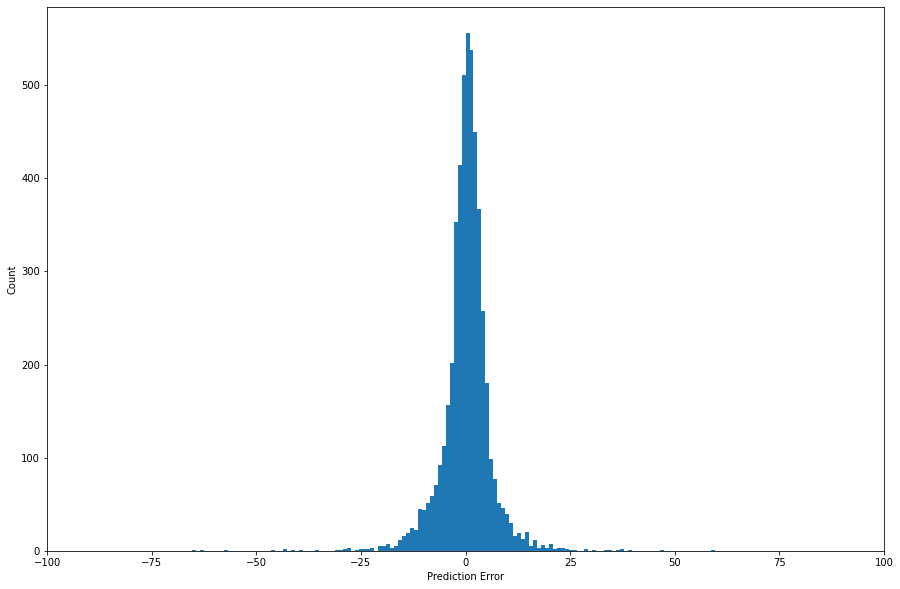

In [ ]:


ytrue=denorm(y_test,df.target)
yhat=denorm(model.predict(X_test),df.target)

model.evaluate(X_test,y_test)
print("sklearn mae：",sklearn.metrics.mean_absolute_error(ytrue,yhat))

gene_hist(ytrue,yhat)


In [ ]:
model

159/159 [==============================] - 1s 5ms/step - loss: 2.0539e-04 - mean_absolute_error: 0.0102
sklearn mae： 11.569531


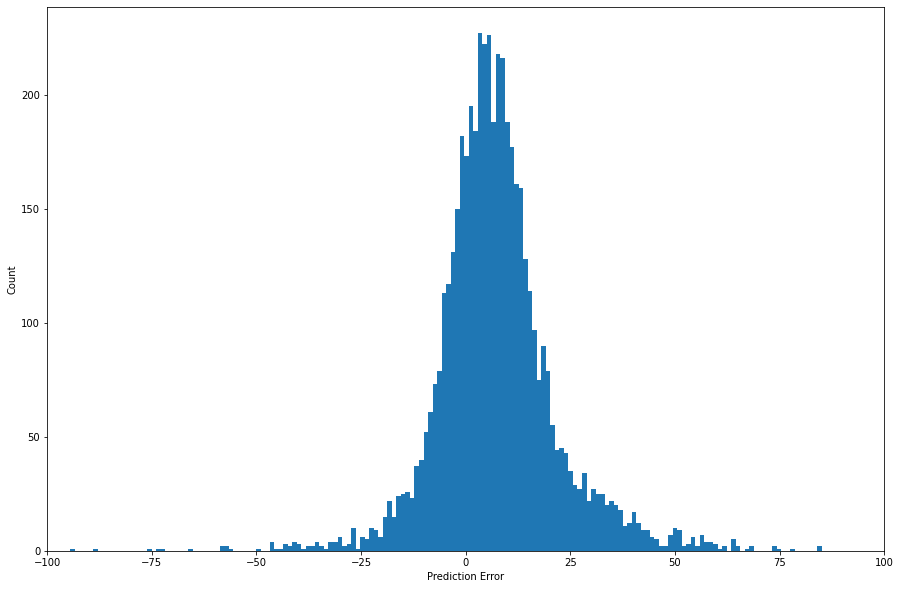

In [ ]:
model2=keras.models.load_model("selu.h5")
model2

ytrue=denorm(y_test,df.target)
yhat=denorm(model2.predict(X_test),df.target)

model2.evaluate(X_test,y_test)
print("sklearn mae：",sklearn.metrics.mean_absolute_error(ytrue,yhat))

gene_hist(ytrue,yhat)

In [ ]:

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def build_model(n_hidden=3, n_neurons=32):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[X.shape[1],X.shape[2]]))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = tf.optimizers.Adam()
    model.compile(loss="mse", optimizer=optimizer)
    return model


keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
782/782 [==============================] - 1s 2ms/step - loss: 8.6404e-04 - val_loss: 1.6326e-04
Epoch 2/100
782/782 [==============================] - 1s 2ms/step - loss: 8.4414e-05 - val_loss: 6.5059e-05
Epoch 3/100
782/782 [==============================] - 1s 2ms/step - loss: 6.3840e-05 - val_loss: 5.0656e-05
Epoch 4/100
782/782 [==============================] - 1s 2ms/step - loss: 6.5160e-05 - val_loss: 8.9418e-05
Epoch 5/100
782/782 [==============================] - 1s 2ms/step - loss: 4.3961e-05 - val_loss: 8.5155e-05
Epoch 6/100
782/782 [==============================] - 1s 2ms/step - loss: 4.9222e-05 - val_loss: 7.4206e-05
Epoch 7/100
782/782 [==============================] - 1s 2ms/step - loss: 4.2295e-05 - val_loss: 4.6107e-05
Epoch 8/100
782/782 [==============================] - 1s 2ms/step - loss: 4.1609e-05 - val_loss: 3.6892e-05
Epoch 9/100
782/782 [==============================] - 1s 1ms/step - loss: 3.8421e-05 - val_loss: 7.9892e-05
Epoch 10/100
782/78

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


param_distribs = {
    "n_hidden": [2,3,4],
    "n_neurons": np.arange(40, 60),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=70,
                  validation_data=(X_val, y_val),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=58, n_hidden=2 ........................................
Epoch 1/70


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


521/521 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 1.6230e-04
Epoch 2/70
521/521 [==============================] - 1s 2ms/step - loss: 1.3258e-04 - val_loss: 9.6111e-05
Epoch 3/70
521/521 [==============================] - 1s 2ms/step - loss: 9.0876e-05 - val_loss: 1.1476e-04
Epoch 4/70
521/521 [==============================] - 1s 2ms/step - loss: 6.8611e-05 - val_loss: 5.3631e-05
Epoch 5/70
521/521 [==============================] - 1s 2ms/step - loss: 6.7003e-05 - val_loss: 4.5929e-05
Epoch 6/70
521/521 [==============================] - 1s 2ms/step - loss: 5.4258e-05 - val_loss: 4.2850e-05
Epoch 7/70
521/521 [==============================] - 1s 2ms/step - loss: 6.3287e-05 - val_loss: 5.7165e-05
Epoch 8/70
521/521 [==============================] - 1s 2ms/step - loss: 5.0594e-05 - val_loss: 6.9305e-05
Epoch 9/70
521/521 [==============================] - 1s 2ms/step - loss: 7.8380e-05 - val_loss: 1.2623e-04
Epoch 10/70
521/521 [======================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.3s remaining:    0.0s


521/521 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 2.2348e-04
Epoch 2/70
521/521 [==============================] - 1s 2ms/step - loss: 1.7584e-04 - val_loss: 1.0594e-04
Epoch 3/70
521/521 [==============================] - 1s 2ms/step - loss: 1.0946e-04 - val_loss: 7.8860e-05
Epoch 4/70
521/521 [==============================] - 1s 2ms/step - loss: 1.1003e-04 - val_loss: 7.7343e-05
Epoch 5/70
521/521 [==============================] - 1s 2ms/step - loss: 7.2603e-05 - val_loss: 7.5378e-05
Epoch 6/70
521/521 [==============================] - 1s 2ms/step - loss: 8.4885e-05 - val_loss: 6.3131e-05
Epoch 7/70
521/521 [==============================] - 1s 2ms/step - loss: 7.8873e-05 - val_loss: 6.6009e-05
Epoch 8/70
521/521 [==============================] - 1s 2ms/step - loss: 7.7400e-05 - val_loss: 6.0237e-05
Epoch 9/70
521/521 [==============================] - 1s 2ms/step - loss: 6.6950e-05 - val_loss: 6.3576e-05
Epoch 10/70
521/521 [======================

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 18.0min finished


782/782 [==============================] - 2s 2ms/step - loss: 4.6973e-04 - val_loss: 1.1922e-04
Epoch 2/70
782/782 [==============================] - 1s 2ms/step - loss: 7.9129e-05 - val_loss: 1.4422e-04
Epoch 3/70
782/782 [==============================] - 1s 2ms/step - loss: 6.9994e-05 - val_loss: 9.9681e-05
Epoch 4/70
782/782 [==============================] - 1s 2ms/step - loss: 7.1986e-05 - val_loss: 9.0330e-05
Epoch 5/70
782/782 [==============================] - 1s 2ms/step - loss: 6.4063e-05 - val_loss: 6.4108e-05
Epoch 6/70
782/782 [==============================] - 1s 2ms/step - loss: 5.5051e-05 - val_loss: 3.7914e-05
Epoch 7/70
782/782 [==============================] - 1s 2ms/step - loss: 4.0688e-05 - val_loss: 3.2745e-05
Epoch 8/70
782/782 [==============================] - 1s 2ms/step - loss: 5.7674e-05 - val_loss: 1.1017e-04
Epoch 9/70
782/782 [==============================] - 1s 2ms/step - loss: 4.8241e-05 - val_loss: 5.7621e-05
Epoch 10/70
782/782 [==================

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f23bb051a58>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'n_hidden': [2, 3, 4],
                                        'n_neurons': array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [ ]:
model.evaluate(X_test, y_test)


159/159 [==============================] - 0s 906us/step - loss: 3.4346e-05


3.434603786445223e-05

In [ ]:
!pip uninstall sklearn


Uninstalling sklearn-0.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/sklearn-0.0.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled sklearn-0.0


In [ ]:
!pip install scikit-learn==0.21.2

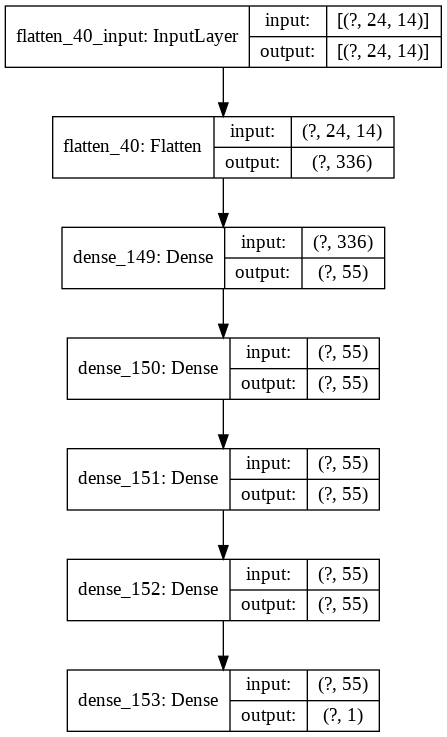

In [ ]:
model = rnd_search_cv.best_estimator_.model
model
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)


In [ ]:


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)



root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



#### dense model use as baseline

#loss: 2.9652e-05 - mean_absolute_error: 0.0034 [2.9652341254404746e-05, 0.0033624102361500263]
#sklearn mae - 3.3048239
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[X.shape[1],X.shape[2]]),                   
    tf.keras.layers.Dense(units=55, activation='relu'),
    tf.keras.layers.Dense(units=55, activation='relu'),
    tf.keras.layers.Dense(units=55, activation='relu'),
    tf.keras.layers.Dense(units=55, activation='relu'),

    tf.keras.layers.Dense(units=1)
])



model.compile(loss="mse",
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

checkpoint_cb = keras.callbacks.ModelCheckpoint("baseline.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb,tensorboard_cb], shuffle=True)


Epoch 1/100
782/782 [==============================] - 2s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0133 - val_loss: 9.8371e-05 - val_mean_absolute_error: 0.0066
Epoch 2/100
782/782 [==============================] - 1s 2ms/step - loss: 8.1850e-05 - mean_absolute_error: 0.0069 - val_loss: 6.6538e-05 - val_mean_absolute_error: 0.0052
Epoch 3/100
782/782 [==============================] - 1s 2ms/step - loss: 6.6287e-05 - mean_absolute_error: 0.0061 - val_loss: 4.9322e-05 - val_mean_absolute_error: 0.0042
Epoch 4/100
782/782 [==============================] - 2s 2ms/step - loss: 5.9070e-05 - mean_absolute_error: 0.0057 - val_loss: 4.1626e-05 - val_mean_absolute_error: 0.0038
Epoch 5/100
782/782 [==============================] - 2s 2ms/step - loss: 5.4755e-05 - mean_absolute_error: 0.0055 - val_loss: 8.4710e-05 - val_mean_absolute_error: 0.0073
Epoch 6/100
782/782 [==============================] - 2s 2ms/step - loss: 5.6624e-05 - mean_absolute_error: 0.0056 - val_loss: 3.5041e-05 

159/159 [==============================] - 0s 1ms/step - loss: 2.9335e-05 - mean_absolute_error: 0.0035
sklearn mae： 3.9680288


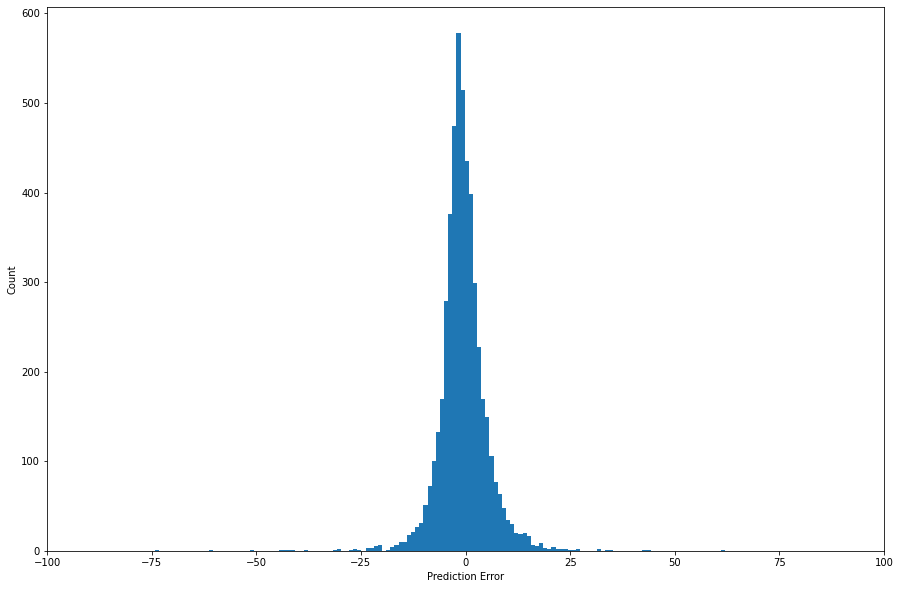

In [ ]:

ytrue=denorm(y_test,df.target)
yhat=denorm(model.predict(X_test),df.target)

model.evaluate(X_test,y_test)
print("sklearn mae：",sklearn.metrics.mean_absolute_error(ytrue,yhat))

gene_hist(ytrue,yhat)


profit is 183.0185546875 position in portfolio is 0
5063 (5063, 5)


,t,yhat,ytrue,profit,position
1,3062.427246,3067.877686,3066.791016,0.000000,1
2,3066.791016,3069.314941,3071.956055,0.000000,1
3,3071.956055,3073.448486,3066.280518,0.000000,1
4,3066.280518,3067.360352,3069.441650,0.000000,1
5,3069.441650,3069.085693,3066.136230,7.014404,0
6,3066.136230,3065.026855,3069.037842,7.014404,0
7,3069.037842,3068.193359,3070.945312,7.014404,0
8,3070.945312,3072.110840,3068.328369,7.014404,1
9,3068.328369,3068.632324,3065.647949,7.014404,1
10,3065.647949,3064.768799,3064.843506,1.717041,0


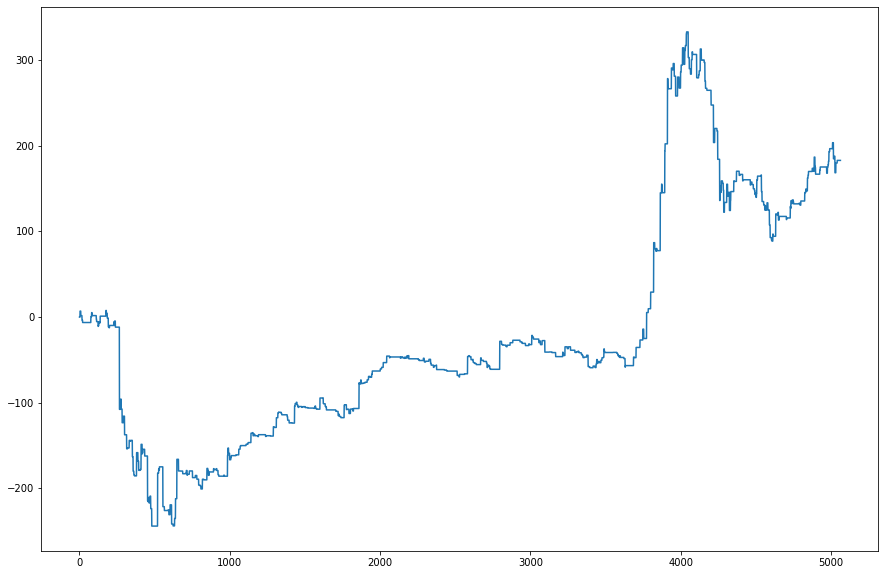

In [ ]:
calculate_profit(ytrue,yhat).head(50)